In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import xarray as xr
import numpy as np
import pymp


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import pylab as pl
import mpl_toolkits.axisartist
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import LogNorm
import string

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, _extract_interface

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

##File of fancy plot style. To use des.mplstyle file you must have an LaTeX distribution in your system
plt.style.use(machine_path+'/opt/mandyoc-scripts/sty/mandyoc.mplstyle')

In [2]:
def calc_mean_temperaure_region(data, Nz, xx, begin, end):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nz: int
        Number of points in Z direction

    xx: numpy.ndarray
        2D grid with x cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    arr: `numpy.ndarray`
        Array containing the horizontal mean of selected region
    '''

    x_region = (xx >= begin) & (xx <= end)
    Nx_aux = len(x_region[0][x_region[0]==True])
    data_sel = data[x_region].reshape(Nz, Nx_aux)
    data_sel_mean = np.mean(data_sel, axis=1)
    
    return data_sel_mean
def Tp_estimate(mean_temp, z, zbot, ztop):
    zcond = (z<=zbot+40) & (z>=ztop+40) #considering air layer

    zcut = z[zcond]
    tcut = mean_temp[zcond]

    params = curve_fit(fit_func, zcut, tcut)
    [a, b] = params[0]

    tfit = a*z + b #temeprature fitted

    #find the mantle potential temperature
    idx = np.where(z == 40.0)[0][0] #air thickness = 40 
    Tp = int(np.round(tfit[idx], 0))

    return Tp, tfit

def fit_func(x, a, b):
    return a*x + b

def calc_and_plot_YSE(ax, T_mean_region, z,
                      clc = 10,
                      thickness_sa = 40 * 1.0e3,
                      thickness_upper_crust = 20 * 1.0e3,
                      thickness_lower_crust = 15 * 1.0e3,
                      thickness_litho = 80 * 1.0e3):
###################################################################################

    # Creating YSE

    L = thickness_litho #select from z axis of the scenario
    N = int(2*thickness_litho/1.0e3 + 1)
    z_yse = np.linspace(0, L, N)
    dz_yse = z_yse[1]-z_yse[0]

    f = interp1d(z, T_mean_region)
    T_interp = f(z_yse/1.0e3)

    rho = np.zeros_like(z_yse)

    #conditions for regions
    uc = (z_yse <= thickness_upper_crust)
    lc = (z_yse > thickness_upper_crust) & (z_yse <= thickness_upper_crust + thickness_lower_crust)
    lm = (z_yse > thickness_upper_crust + thickness_lower_crust)

    rho[uc]=2700.0
    rho[lc]=2800.0
    rho[lm]=3354.0
    g = 10.0

    P = 0.0
    Paux = 0.0
    for i in range(1, N):
        Paux += dz_yse*rho[i]*g
        P = np.append(P, Paux)

    phi = 2.0*np.pi/180.0
    c0 = 4.0E6
    sigma_min = c0 * np.cos(phi) + P * np.sin(phi)

    phi = 15.0*np.pi/180.0
    c0 = 20.0E6
    sigma_max = c0 * np.cos(phi) + P * np.sin(phi)

    #rheological params
    Q = np.zeros_like(z_yse)
    A = np.zeros_like(z_yse)
    n = np.zeros_like(z_yse)
    V = np.zeros_like(z_yse)
    C = np.zeros_like(z_yse)

    Q[uc]=222000.0
    Q[lc]=222000.0
    Q[lm]=540000.0

    A[uc]=8.574E-28
    A[lc]=8.574E-28
    A[lm]=2.4168E-15

    n[uc]=4.0
    n[lc]=4.0
    n[lm]=3.5

    V[uc]=0.0
    V[lc]=0.0
    V[lm]=25.0E-6

    #strain rate (sr)
    sr = 1.0E-15

    #gas constant
    R = 8.314

    #print(n)

    #Temperature Kelvin
    TK = T_interp + 273

    #Viscosity
    #Choosing C for layers
    C[uc]=1.0
    C[lc] = clc
    C[lm]=1.0
    
    visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))

    sigma_v = visc * sr

    cond = sigma_v>sigma_max
    sigma_v[cond]=sigma_max[cond]

    ax.plot(sigma_v/1.0E9, z_yse/1000, linestyle='-', color='black', alpha=0.7)

    
    cr = 255.
    color_uc = (228./cr, 156./cr, 124./cr)
    color_lc = (240./cr, 209./cr, 188./cr)
    color_lit = (155./cr, 194./cr, 155./cr)
    color_ast = (207./cr, 226./cr, 205./cr)

    #filling inside YSE
    ax.fill_betweenx(z_yse[uc]/1000, z_yse[uc]*0, sigma_v[uc]/1.0E9, color=color_uc, ec="k")
    ax.fill_betweenx(z_yse[lc]/1000, z_yse[lc]*0, sigma_v[lc]/1.0E9, color=color_lc, ec="k")
    ax.fill_betweenx(z_yse[lm]/1000, z_yse[lm]*0, sigma_v[lm]/1.0E9, color=color_lit, ec="k")

    # gray=0.
    # ax.plot(sigma_min/1.0E9, z_yse/1000, "--", color=(gray,gray,gray))
        # ax.plot(sigma_max/1.0E9, z_yse/1000, "--", color=(gray,gray,gray))

    ax.set_xlim([0, 0.5])
    ax.set_xticks(np.linspace(0, 0.5, 6))
    # ax.set_ylim([thickness_litho/1.0e3, 0])
    ax.set_ylim([200, 0])
    ax.set_yticks(np.linspace(0, 200, 11))


In [9]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT200_HprodAst_Lx3000km'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT290_HprodAst_Lx3000km'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT350_HprodAst_Lx3000km'
# scenario = '/Doutorado/cenarios/mandyoc/keel/stable_DT200_keel_HprodAst'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT200_HprodAst_Lx3000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT290_HprodAst_Lx3000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT350_HprodAst_Lx3000km_ck'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT200_HprodAst_Lx4000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT290_HprodAst_Lx4000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT350_HprodAst_Lx4000km_ck'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT290_HprodAst_Lx4000km_ck_aw'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT350_HprodAst_Lx4000km_ck_aw'

#Thermal boundary condition fixed
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf_sc'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbwo'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT350_HprodAst_Lx4000km_ck_aw_tbcf'

#PARTIAL
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbwo/mbwo_partial'
scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/mbdo_partial'


# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    external_media = 'Joao_Macedo'
    if(path[1] == 'home'):
        model_path = f'/media/joao_macedo/{external_media}{scenario}'
    elif(path[1] == 'Users'):
        model_path = f'/Volumes/{external_media}{scenario}'

print(f'Model Path: {model_path}\n')

model_name = scenario.split('/')[-1]
print(f'Model name: {model_name}')

# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
print(f'Output Path: {output_path}')

if not os.path.isdir(output_path):
    os.makedirs(output_path)

Model Path: /media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/mbdo_partial

Model name: mbdo_partial
Output Path: /media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/mbdo_partial/_output


In [10]:
dataset = xr.open_dataset(f'{model_path}/_output_temperature.nc')

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

instant = dataset.time[-1]

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(dataset.info)

<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (x: 401, time: 265, z: 71)
Coordinates:
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 3.98e+06 3.99e+06 4e+06
  * time         (time) float64 0.0 2.5 5.0 7.5 10.0 ... 652.5 655.0 657.5 660.0
    step         (time) int32 ...
  * z            (z) float64 -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    temperature  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                401
    nz:                                71
    lx:                                4000000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:                 s^(-1)
    pressure_u

# Plot frames to create video/gif (pymp)

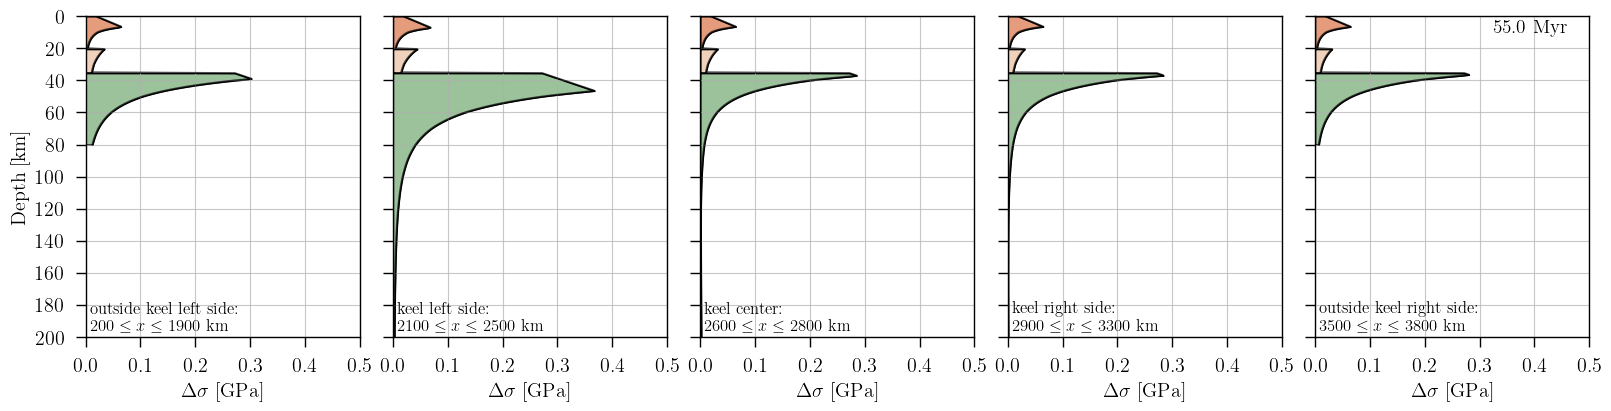

In [11]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 1#5

# start = 0
# end = 1
# step = 1#5

with pymp.Parallel() as p:
    for i in p.range(start, end+step, step):
        # data = dataset.isel(time=i)
        # per = np.round(100*(i+1-start)/(end-start), 2)
        # text = f"Time: {np.round(float(dataset.isel(time=i).time), 2)} Myr; Step: {int(dataset.isel(time=i).step)}/{int(dataset.step.max())}, ({per:.2f}%)."

        data = dataset.temperature[i].values.T #Nz vs Nx
        time = np.round(dataset.time[i].values, 2)

        ############################################################################################

        #Calculating mean temperature profile for different regions  

        #only for shift craton
        shift_craton = True
        # shift_craton = False

        if(shift_craton):
            shift = 700.0e3 #m
        else:
            shift = 0.0e3

        xcenter = (Lx/2)/1.0e3 + shift/1.0e3

        keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - 600, xcenter - 200)
        keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - 100, xcenter + 100)
        keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 200, xcenter + 600)

        out_mean_l = calc_mean_temperaure_region(data, Nz, xx, 200, xcenter - 800)
        out_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 800, Lx/1.03 - 200)

        thickness_sa = 40.0e3
        z_aux = z - thickness_sa/1.0e3
        cond1 = z_aux >= 0

        temperature_profiles = [out_mean_l, keel_mean_l, keel_mean_c, keel_mean_r, out_mean_r]
        Hlits = [80.0e3, 200.0e3, 200.0e3, 200.0e3, 80.0e3]

        plt.close()
        fig, axs = plt.subplots(1, 5, figsize=(16,4), sharex=True, sharey=True, constrained_layout=True)
        axs.flatten()

        for ax, temp_profile, thickness_litho in zip(axs, temperature_profiles, Hlits):
            calc_and_plot_YSE(ax, temp_profile[cond1], z_aux[cond1], thickness_litho=thickness_litho)


        #Set plot details
        locations = [f'outside keel left side:\n $200 \leq x \leq {int(xcenter - 800)}$ km',
                    f'keel left side:\n ${int(xcenter - 600)} \leq x \leq {int( xcenter - 200)}$ km',
                    f'keel center:\n ${int(xcenter - 100)} \leq x \leq {int( xcenter + 100)}$ km',
                    f'keel right side:\n ${int(xcenter + 200)} \leq x \leq {int( xcenter + 600)}$ km',
                    f'outside keel right side:\n ${int(xcenter + 800)} \leq x \leq {int(Lx/1.0e3 - 200)}$ km'
                    ]

        for ax, location in zip(axs, locations):
            ax.grid('-k', alpha=0.7)
            ax.set_xlabel(r'$\Delta\sigma$ [GPa]')
            ax.text(0.015, 0.02, location, fontsize=12, transform=ax.transAxes)
            
        axs[-1].text(0.65, 0.95, f"{time} Myr", fontsize=14, transform=axs[-1].transAxes)
        axs[0].set_ylabel('Depth [km]')

        figname = f'YSE_{model_name}_{str(int(dataset.step[i].values)).zfill(8)}'
        # print(figname)
        fig.savefig(f'{output_path}/{figname}.png', dpi=400)

In [12]:
fps = 30

videoname = f'{model_path}/_output/YSE_{model_name}'
!rm {videoname}.mp4
!ffmpeg -r {fps} -f image2 -s 1920x1080 -pattern_type glob -i '{videoname}_*.png' -vcodec libx264 -vf 'pad=ceil(iw/2)*2:ceil(ih/2)*2' -r 24 -y -an -crf 25 -pix_fmt yuv420p {videoname}.mp4


rm: não foi possível remover '/media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/mbdo_partial/_output/YSE_mbdo_partial.mp4': Arquivo ou diretório inexistente
ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 12.2.0 (conda-forge gcc 12.2.0-19)
  configuration: --prefix=/home/joao_macedo/opt/anaconda3/envs/mpy --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype 

In [13]:
gifname = f'{model_path}/_output/YSE_{model_name}'
!rm {gifname}.gif
!ffmpeg -ss 0 -t 13 -i '{gifname}.mp4' -vf "fps=30,scale=1080:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" -loop 0 {gifname}.gif

rm: não foi possível remover '/media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/mbdo_partial/_output/YSE_mbdo_partial.gif': Arquivo ou diretório inexistente
ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 12.2.0 (conda-forge gcc 12.2.0-19)
  configuration: --prefix=/home/joao_macedo/opt/anaconda3/envs/mpy --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype 

In [8]:
# !zip {model_name}_imgs.zip YSE_{model_name}_*.png
# !rm YSE_{model_name}_*.png

In [ ]:
np.round(time, 1)

# Plot a single frame

In [ ]:
#Extracting temperature dataset
i = -1
data = dataset.temperature[i].values.T #Nz vs Nx
time = dataset.time[i].values

############################################################################################

#Calculating mean temperature profile for different regions
xcenter = (Lx/2)/1.0e3
keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - 600, xcenter - 200)
keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - 100, xcenter + 100)
keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 200, xcenter + 600)

out_mean_l = calc_mean_temperaure_region(data, Nz, xx, 200, xcenter - 800)
out_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 800, Lx/1.03 - 200)

thickness_sa = 40.0e3
z_aux = z - thickness_sa/1.0e3
cond1 = z_aux >= 0

temperature_profiles = [out_mean_l, keel_mean_l, keel_mean_c, keel_mean_r, out_mean_r]
Hlits = [80.0e3, 200.0e3, 200.0e3, 200.0e3, 80.0e3]

plt.close()
fig, axs = plt.subplots(1, 5, figsize=(16,4), sharex=True, sharey=True, constrained_layout=True)
axs.flatten()

for ax, temp_profile, thickness_litho in zip(axs, temperature_profiles, Hlits):
    calc_and_plot_YSE(ax, temp_profile[cond1], z_aux[cond1], thickness_litho=thickness_litho)


#Set plot details
locations = [f'outside keel left side:\n $200 \leq x \leq 700$ km',
             f'keel left side:\n $900 \leq x \leq 1300$ km',
             f'keel center:\n $1400 \leq x \leq 1600$ km',
             f'keel right side:\n $1700 \leq x \leq 2100$ km',
             f'outside keel right side:\n $2300 \leq x \leq 2800$ km'
            ]

for ax, location in zip(axs, locations):
    ax.grid('-k', alpha=0.7)
    ax.set_xlabel(r'$\Delta\sigma$ [GPa]')
    ax.text(0.015, 0.02, location, fontsize=12, transform=ax.transAxes)
    
axs[-1].text(0.65, 0.95, f"{time} Myr", fontsize=14, transform=axs[-1].transAxes)
axs[0].set_ylabel('Depth [km]')

figname = f'YSE_{model_name}_{int(time)}_Myr'
print(figname)
fig.savefig(f'{output_path}/{figname}.png', dpi=400)
fig.savefig(f'{output_path}/{figname}.pdf', dpi=400)